<a href="https://colab.research.google.com/github/SANJAY-KUMAR-7/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of Indian Product Reviews on Amazon**
##Sentiment Analysis in Python

In [ ]:
#importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
plt.style.use('ggplot')
import re
from wordcloud import WordCloud
from textblob import TextBlob

In [ ]:

from google.colab import files


uploaded = files.upload()

Saving amazon_vfl_reviews.csv to amazon_vfl_reviews.csv


In [ ]:
#Loading the data
df = pd.read_csv('amazon_vfl_reviews.csv')
print(df.shape)

(2782, 5)


In [ ]:
df.head(5)

,asin,name,date,rating,review
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...


The dataset comprises of 2782 rows and 5 columns:-

asin : Amazon Standard Identification Number - a unique number for every product

name : Name of the product

date : Date on which review was posted

rating : Rating given to the product ( out of 5 )

review : Review given to the product

### Quick EDA



In [ ]:
df.isnull().sum()


asin      0
name      0
date      0
rating    0
review    4
dtype: int64

In [ ]:
df.dropna(inplace=True)
df = df.reset_index()
df = df.drop(['index'], axis = 1)
df.shape

(2778, 5)

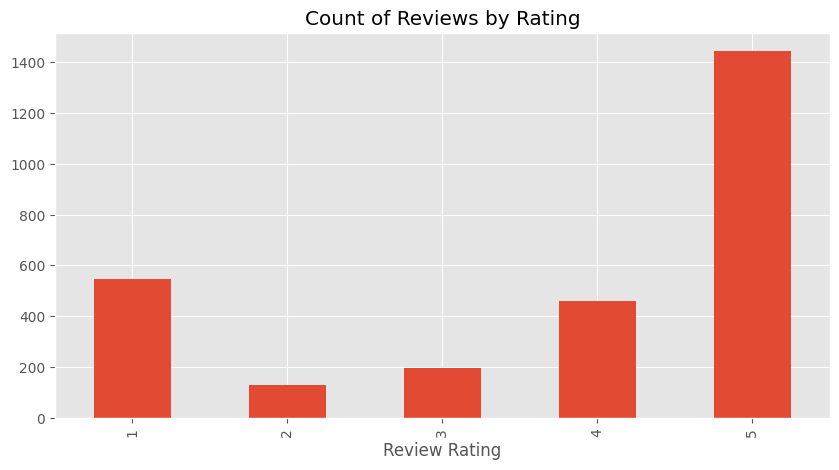

In [ ]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Rating',
          figsize=(10, 5))
ax.set_xlabel('Review Rating')
plt.show()

## Basic NLTK

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
example = df['review'][200]
print(example)

Great productBut one thing I want to ask Amazon  being a Global Chain Market why they are using cheap plastic for packaging ?As they are Global the should focus on Bio -degradable plastic for packaging please mail me about this .Thank you


In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['I', 'do', 'have', 'it', 'sometimes', '.', 'But', 'the', 'quality', 'has']

In [ ]:
stop_words = stopwords.words('english')

---
## Step 1. VADER Seniment Scoring



We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
1. Stop words are removed
2. each word is scored and combined to a total score.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('It was a great Product')

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [ ]:
sia.polarity_scores('Not worth buying')

{'neg': 0.454, 'neu': 0.546, 'pos': 0.0, 'compound': -0.1695}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.041, 'neu': 0.704, 'pos': 0.254, 'compound': 0.851}

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    myid = row['asin']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/2778 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'asin'})
vaders = vaders.merge(df, how='left')

In [ ]:
# Now we have sentiment score and metadata
vaders.head()

,asin,neg,neu,pos,compound,name,date,rating,review
0,B07W7CTLD1,0.0,0.748,0.252,0.9704,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,0.0,0.748,0.252,0.9704,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,0.0,0.748,0.252,0.9704,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...
3,B07W7CTLD1,0.0,0.748,0.252,0.9704,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...
4,B07W7CTLD1,0.0,0.748,0.252,0.9704,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...


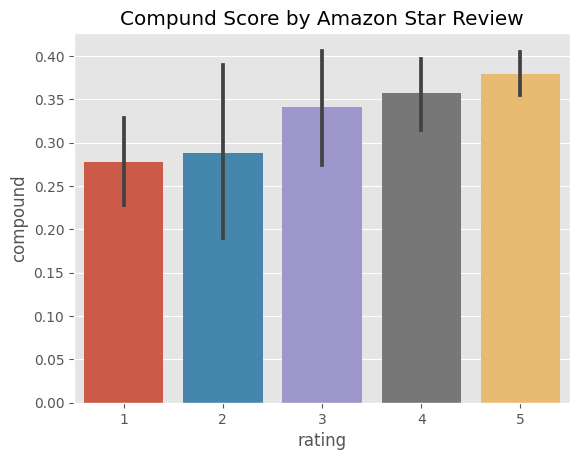

In [ ]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()



--------



### Proportion of Sentiments
Here we will use TextBlob library to perform Sentiment Analysis on product reviews. TextBlob is a Python library for processing textual data.

For calculating sentiment, we will calculate polarity. It simply means emotions expressed in a sentence.

Polarity of a sentence lies between ( -1 to 1 ) -1 being Negative and 1 being Positive. A polarity of 0 means Neutral sentiment.

In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

df['polarity_score'] = df['review'].\
   apply(lambda x : polarity(x))

def sentiment(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'

df['polarity'] = df['polarity_score'].\
   map(lambda x: sentiment(x))
fig = go.Figure(data=[go.Pie(labels=df['polarity'].value_counts().index.tolist(),
                           values=df['polarity'].value_counts().tolist(),
                            marker=dict(colors=['#006400','#8B0000','#add8e6']))])

fig.update_layout(title_text='Proportion of Sentiments',title_x=0.5,
                  template='plotly_dark')
fig.show()

Most of the reviews are Positive.

*   About 8.42% are Neutral reviews.
*   Out of 2778 reviews, 410 are Negative.







-----
# WordCloud



In [ ]:
def get_data(df,senti):
    s_df = df[df['polarity']==senti].reset_index()

    s_corpus = []
    for i in range(0,len(s_df)):
        text = re.sub('[^a-zA-Z]', ' ', s_df['review'][i])
        text = text.lower()
        text = text.split()
        text = [word for word in text if not word in stop_words]
        text = ' '.join(text)
        s_corpus.append(text)
    return s_corpus

p_corpus = get_data(df,'positive')
n_corpus = get_data(df,'negative')
nt_corpus = get_data(df,'neutral')

## WordCcloud for Positive sentiments

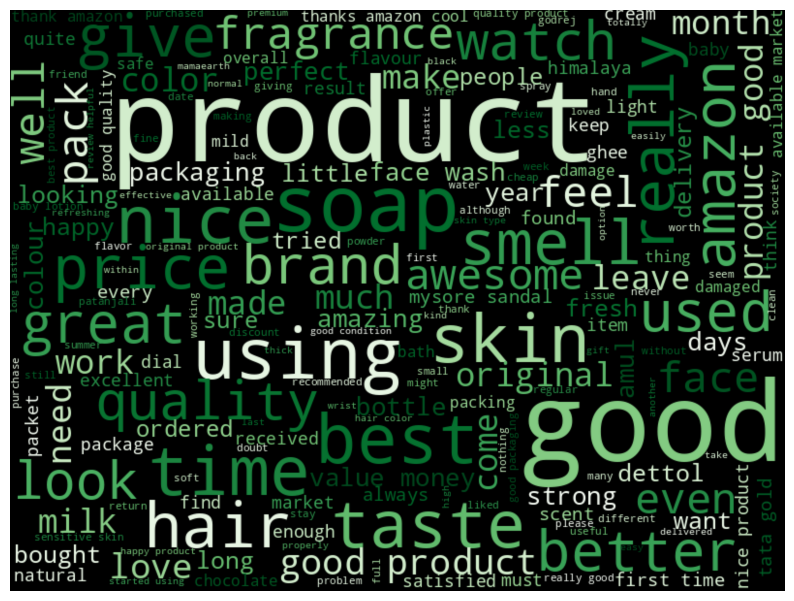

In [ ]:
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'Greens',
                       margin = 0,
                       max_words = 200,
                       min_word_length = 4,
                       max_font_size = 120,
                       background_color = 'black').generate(' '.join(p_corpus))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.axis('off')
plt.show()

## WordCloud for negative sentiments

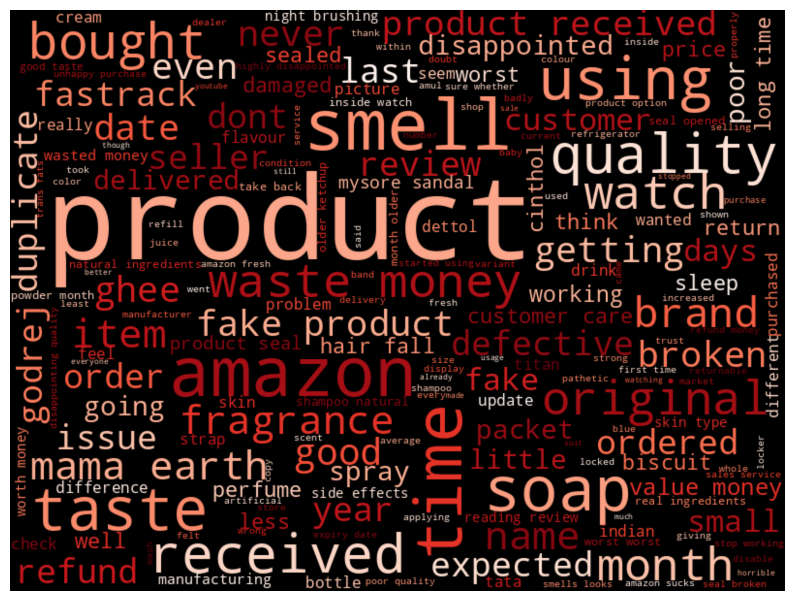

In [ ]:
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'Reds',
                       margin = 0,
                       max_words = 200,
                       min_word_length = 4,
                       max_font_size = 120,
                       background_color = 'black').generate(' '.join(n_corpus))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.axis('off')
plt.show()

### Wordcloud for neutral sentiments

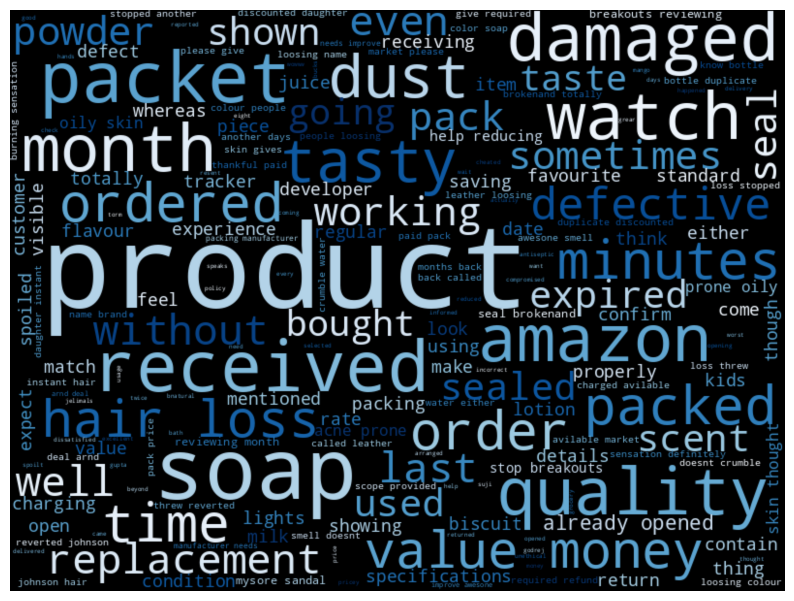

In [ ]:
word_cloud = WordCloud(width = 800,
                       height = 600,
                       colormap = 'Blues',
                       margin = 0,
                       max_words = 200,
                       min_word_length = 4,
                       max_font_size = 120,
                       background_color = 'black').generate(' '.join(nt_corpus))

plt.figure(figsize = (10, 10))
plt.imshow(word_cloud, interpolation = 'gaussian')
plt.axis('off')
plt.show()

From the above wordclouds, we can observe that:-

Words like **good, better, awesome** are used to describe the products highlighting a positive sentiment.
For describing negative sentiments, words used are **fake, waste**.